## Data Loading

In [ ]:
import polars as pl

df_dsa = pl.read_ipc("data/Beer_Analyzer_Data_full.feather")
df_nir = pl.read_ipc("data/Fermentation_NIR_absorbance_full.feather")

df_dsa = df_dsa.with_columns(
    pl.col('BatchName').cast(pl.Utf8)
)

: 

Number of spectra and samples from the individual batches

In [ ]:
counts_spectra = df_nir["BatchName"].value_counts().sort("BatchName")
counts_samples = df_dsa["BatchName"].value_counts().sort("BatchName")

counts = counts_spectra.join(counts_samples, on="BatchName")
counts = counts.rename({"count": "n_spectra", "count_right": "n_samples"})

counts

## Outlier detection

In [ ]:
from NIRBeer.outlier_detection import detect_outliers
from chemotools.feature_selection import RangeCut

rcbi = RangeCut(30, -30)

result = detect_outliers(df_nir, range_cut=rcbi, alpha=0.01, var_threshold=0.95)

print("Removed", df_nir.shape[0] - result.num_inliers, "outliers")

In [ ]:
result.df_inliers

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
scatter = plt.scatter(result.t2, result.q, c=result.inliers_mask, cmap="bwr", alpha=0.5)   
plt.axvline(result.t2_limit, color="black", ls="--")
plt.axhline(result.q_limit, color="black", ls="--")
plt.xlabel("Hotelling's T$^2$")
plt.ylabel("Q Residuals") 

# Add text labels for the limit lines on the main plot
plt.text(200, plt.ylim()[1] * 0.95, f'T² limit = {result.t2_limit:.2f}', 
         ha='left', va='top', rotation=0, fontsize=9, backgroundcolor='white')
plt.text(plt.xlim()[1] * 0.3, 3, f'Q limit = {result.q_limit:.2f}', 
         ha='left', va='bottom', rotation=0, fontsize=9, backgroundcolor='white')

# Calculate inliers and outliers counts
inliers_count = np.sum(result.inliers_mask)
outliers_count = np.sum(~result.inliers_mask)
total_count = len(result.inliers_mask)

# Add textbox with counts in upper right corner
textstr = f'Inliers: {inliers_count}\nOutliers: {outliers_count}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(200, plt.ylim()[1] * 0.75, textstr, fontsize=10,
         va='top', ha='left', bbox=props)

# Add legend with scatter markers
plt.scatter([], [], c='red', alpha=0.5, label='Inliers')
plt.scatter([], [], c='blue', alpha=0.5, label='Outliers')
plt.legend()  # Moved legend to lower left to avoid overlap

# Create inset axes in the right bottom corner
inset_ax = plt.axes([0.5, 0.3, 0.35, 0.35])  # [left, bottom, width, height]

# Plot the same data on the inset axes (without text labels)
inset_ax.scatter(result.t2, result.q, c=result.inliers_mask, cmap="bwr", alpha=0.5, s=10)
inset_ax.axvline(result.t2_limit, color="black", ls="--", linewidth=1)
inset_ax.axhline(result.q_limit, color="black", ls="--", linewidth=1)

# Set the limits for the zoomed-in region
inset_ax.set_xlim(0, result.t2_limit * 1.5)
inset_ax.set_ylim(0, result.q_limit * 1.5)

# Add labels to inset (optional)
inset_ax.set_xlabel("T$^2$", fontsize=8)
inset_ax.set_ylabel("Q", fontsize=8)
inset_ax.tick_params(labelsize=6)

plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_7468\1774648781.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust layout to make space for colorbar


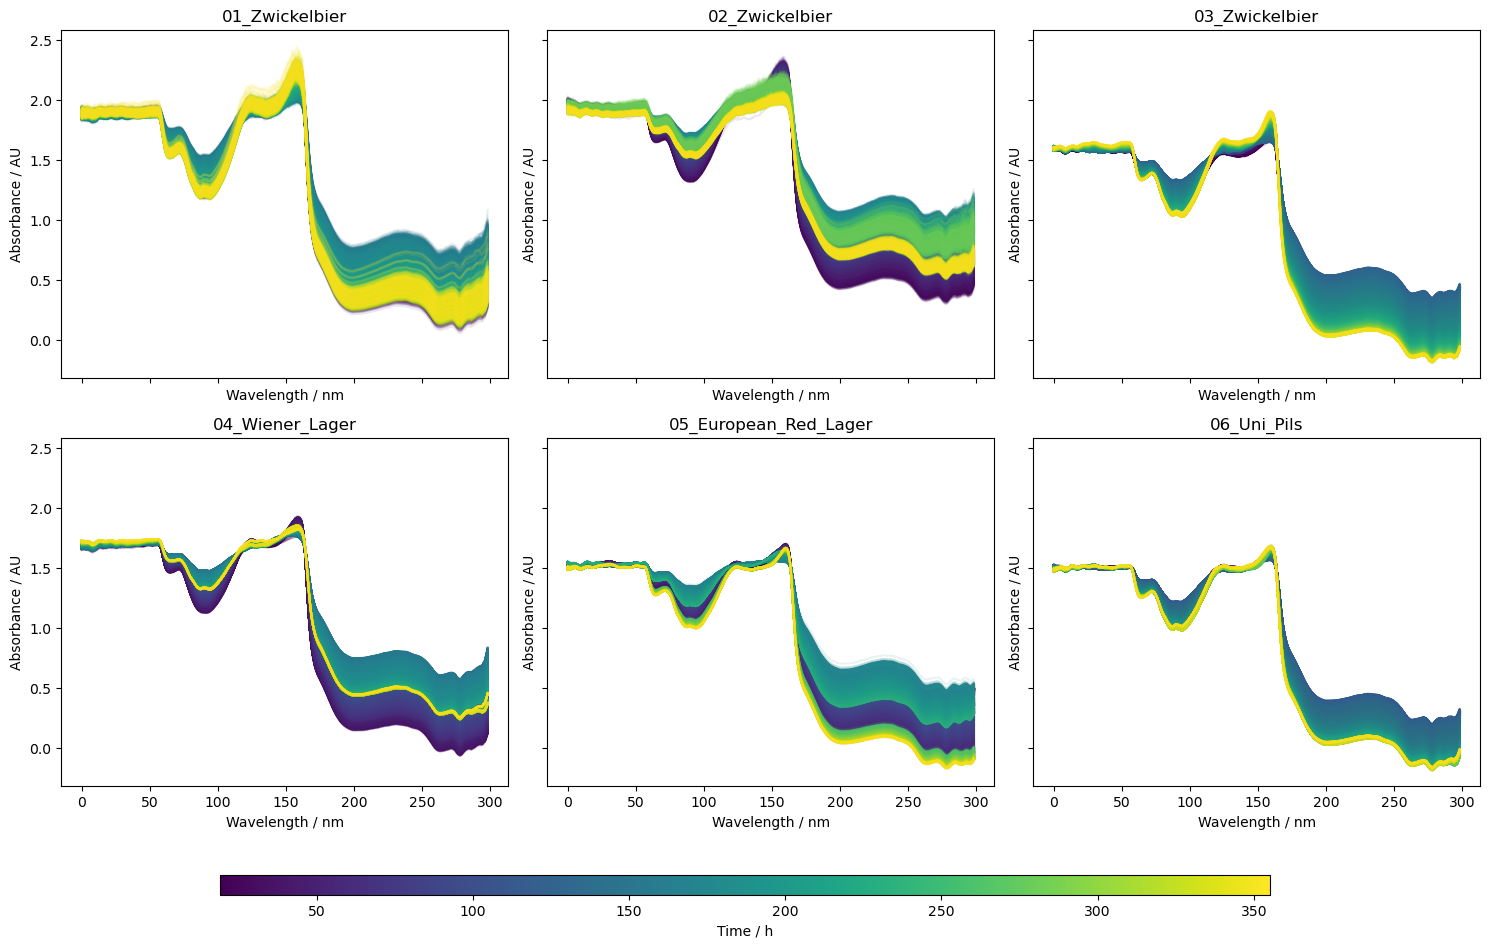

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import numpy as np

df_nir_clean = result.df_inliers


batches = df_nir_clean["BatchName"].unique().sort().to_list()
n_batches = len(batches)
n_cols = 3
n_rows = int(np.ceil(n_batches / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
rcbi = RangeCut(30, -30)
# Create a colormap for time values
cmap = cm.viridis  # You can choose any colormap you prefer: plasma, inferno, magma, coolwarm, etc.

for i, batch in enumerate(batches):
    ax = axes[i // n_cols, i % n_cols]
    batch_data = df_nir_clean.filter(pl.col("BatchName") == batch)
    spectra = batch_data.select(pl.col("^WL.*$")).to_numpy()
    time_values = batch_data.select(pl.col("CumulativeTime")).to_numpy().flatten()
    
    spectra = rcbi.fit_transform(spectra)
    
    # Normalize time values for colormap
    norm = Normalize(vmin=time_values.min(), vmax=time_values.max())
    
    # Plot each spectrum with color based on time
    for j, spectrum in enumerate(spectra):
        color = cmap(norm(time_values[j]))
        ax.plot(spectrum, color=color, alpha=0.1)
    
    ax.set_title(batch)
    ax.set_xlabel("Wavelength / nm")
    ax.set_ylabel("Absorbance / AU")

# Add a horizontal colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Time / h')

plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust layout to make space for colorbar
plt.show()